In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import torch.nn.functional as F

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import fastai
import torch.nn as nn

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

## Initial setup

### Data

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [0]:
model = Model(m, nh, 10)

In [0]:
pred = model(x_train)

## Loss Function

### Cross Entropy Loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$
or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$
In practice, we will need the log of the softmax when we calculate the loss.

In [0]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [0]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$
But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [49]:
y_train[:3]

tensor([5, 0, 4])

Our first three values are 5,0,4

In [50]:
sm_pred[0][5]

tensor(-2.3628, grad_fn=<SelectBackward>)

We can see the probability of the first input being 5 

In [51]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.3628, -2.3967, -2.1274], grad_fn=<IndexBackward>)

We can print multiple probabilities this way. These are probabilities for the first three values being correct.


In [52]:
y_train.shape[0]

50000

### Negative log likelihood

In [0]:
def nll(inputs, targets):
    return -inputs[range(targets.shape[0]), targets].mean()

In [0]:
loss = nll(sm_pred, y_train)

In [55]:
loss

tensor(2.3164, grad_fn=<NegBackward>)

Note that the formula

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$
gives a simplification when we compute the log softmax, which was previously defined as (x.exp()/(x.exp().sum(-1,keepdim=True))).log()



In [0]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [0]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the LogSumExp trick. The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$
where a is the maximum of the $x_{j}$.

In [0]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

In [0]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our log_softmax function.

In [0]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [0]:
test_near(nll(log_softmax(pred), y_train), loss)

In [0]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

Then use PyTorch's implementation.

In [0]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy.

In [0]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:

* get the output of the model on a batch of inputs
* compare the output to the labels we have and compute a loss
* calculate the gradients of the loss with respect to every parameter of the model
* update said parameters with those gradients to make them a little bit better


In [0]:
loss_func = F.cross_entropy

In [0]:
#export
def accuracy(out, yb):
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [63]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 3.1093, -3.2875, -2.6611,  3.2415, -6.1680, 11.3483, -0.4206, -0.5457,
         -3.1052,  0.6614], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [64]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(0.1566, grad_fn=<NllLossBackward>)

In [65]:
accuracy(preds, yb)

tensor(0.9062)

In [0]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [66]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1566, grad_fn=<NllLossBackward>), tensor(0.9062))

## Using parameters and optim

**Parameters**

Use nn.Module.__setattr__ and move relu to functional:

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m, nh, 10)

In [69]:
for name, l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [70]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [71]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    model.zero_grad()

In [0]:
fit()

In [76]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3129, grad_fn=<NllLossBackward>), tensor(0.9219))

PyTorch overrides the __setattr__ function in nn.Module so that the submodules you define are properly registered as parameters of the model.

In [0]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): 
            self._modules[k] = v
        super().__setattr__(k, v)
            
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [98]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [99]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

`__setattr__` will be called every time when something is assigned to self. Our `__setattr__` will first check that variable name is not starting with underscore. When there is underscore before a variable it mean that it should be handled as private.

## Registering modules

PyTorch have already made this functionality and we can use it by setting nn.Module as parent class.

In [0]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [0]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
            return x

In [0]:
model = Model(layers)

In [117]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [118]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

TypeError: ignored

Next we modify the code so it can take a list of layers,

nn.ModuleList
nn.ModuleList does this for us.

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
            
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
            return x

In [0]:
model = SequentialModel(layers)

In [123]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [0]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

**TODO: Validate above**

nn.Sequential
nn.Sequential is a convenient class which does the same as the above:

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [131]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3411, grad_fn=<NllLossBackward>), tensor(0.9375))

In [132]:

model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

**optim**

Let's replace our previous manually coded optimization step:

```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```
    
and instead use just:

```
opt.step()
opt.zero_grad()
```

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [0]:
opt = Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        

In [138]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1662, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in optim.SGD (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [0]:
#export
from torch import optim

In [0]:
# optim.SGD.step??

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [142]:

model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2822, grad_fn=<NllLossBackward>)

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        

In [144]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.3047, grad_fn=<NllLossBackward>), tensor(0.9375))

## Dataset and DataLoader

### Dataset


It's clunky to iterate through minibatches of x and y values separately:

```
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
 ```
Instead, let's do these two steps together, by introducing a Dataset class:

```
xb,yb = train_ds[i*bs : i*bs+bs]
```

In [0]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i],self.y[i]

In [0]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [147]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [0]:
model,opt = get_model()

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [150]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0984, grad_fn=<NllLossBackward>), tensor(0.9375))

DataLoader
Previously, our loop iterated over batches (xb, yb) like this:

```
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:
```
for xb,yb in train_dl:
```

In [0]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): 
            yield self.ds[i:i+self.bs]

In [0]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [0]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

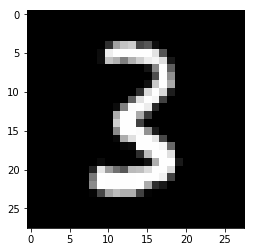

In [155]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [0]:
model,opt = get_model()

In [0]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:

            pred = model(xb)
            loss = loss_func(pred,yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [159]:
fit()


loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0253, grad_fn=<NllLossBackward>), tensor(1.))

## Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [0]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): 
            yield self.idxs[i:i+self.bs]

In [0]:
small_ds = Dataset(*train_ds[:10])

In [162]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [163]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [164]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([3, 8, 5]), tensor([7, 4, 0]), tensor([9, 2, 6]), tensor([1])]

In [0]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: 
            yield self.collate_fn([self.ds[i] for i in s])

In [0]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [0]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

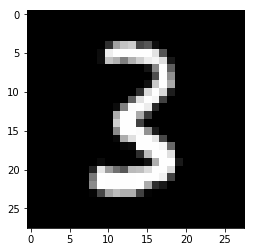

In [175]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(4)

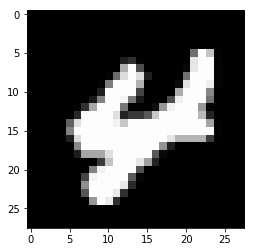

In [176]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(1)

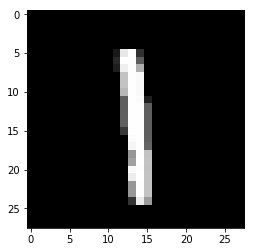

In [177]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [178]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0983, grad_fn=<NllLossBackward>), tensor(0.9688))

## PyTorch DataLoader

In [0]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [0]:
xb,yb = next(iter(train_dl))

In [182]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2784, grad_fn=<NllLossBackward>), tensor(0.9375))

Most of the time we don’t need our own sampler or collate function which is why we can just use the defaults by setting shuffle=true

In [0]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [0]:
xb,yb = next(iter(train_dl))

In [185]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0661, grad_fn=<NllLossBackward>), tensor(0.9688))

## Validation

The final thing we want to do is to use validation set. We do this by adding another loop after the training loop where we keep track of loss and accuracy. We don’t calculate gradients inside this loop because we don’t want to use validation set for training.

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

model.train() and model.eval() looks something complicated but it only sets training parameter inside the model object to true or false. Why we need this? Some layers have different kind of behavior whether it is training or testing. For example dropout is not dropping any values when we are doing validation because that would be just stupid.

One big problem in implementation above is that the valid is not calculating average reward and average loss correctly when batch size varies.


**Question:** Why we need to zero our gradients in PyTorch? If we don’t zero the gradients in every loop it is going to add the new gradients to the old ones. Then why can’t PyTorch just zero the grads automatically? This is because sometimes we want to use multiple different modules and if PyTorch would automatically zero the gradients we couldn’t do this. One important implementation of this is that we can use bigger batch sizes than our computer could normally use. For example if your computer can run certain model with batch size of 32 using this it could run as big batch size as you want. It is not faster but it is updating the weights the same way bigger batch size would do. For example if we use batch size of 32 and zero the gradients only every other loop it is updating the weights same way 64 batch size would do.

In [0]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [188]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.3742) tensor(0.8843)
1 tensor(0.2323) tensor(0.9286)
2 tensor(0.1073) tensor(0.9696)
3 tensor(0.1020) tensor(0.9695)
4 tensor(0.1150) tensor(0.9658)
